## Imports

In [1]:
import pickle

with open("../temp/child_to_parent_categories.pkl", "rb") as fd:
    obj = pickle.load(fd)

obj

{'.NET': ['CategoryHasRSS', 'Языки программирования'],
 '1C': ['CategoryHasRSS', 'Технологии крупных вендоров'],
 'ALTLinux на Эльбрусе': ['ALT Linux', 'CategoryHasRSS', 'Linux для Эльбруса'],
 'ALT Linux': ['CategoryHasRSS', 'Linux-дистрибутивы для Enterprise'],
 'AR': ['CategoryHasRSS', 'NUI', 'Компьютерное зрение'],
 'AWS': ['CategoryHasRSS', 'PAAS', 'Облачные сервисы'],
 'Accessibility': ['CategoryHasRSS', 'Юзабилити'],
 'Agile': ['CategoryHasRSS', 'Методологии управления'],
 'Agile&Lean Mindset': ['Agile-культура', 'CategoryHasRSS'],
 'Agile-культура': ['Agile', 'CategoryHasRSS', 'Культура организаций'],
 'Agile-масштабирование': ['Agile', 'CategoryHasRSS'],
 'Agile-преобразования': ['Agile',
  'CategoryHasRSS',
  'Организационные изменения'],
 'Agile Introduction': ['Agile', 'CategoryHasRSS'],
 'Agile process': ['Agile', 'CategoryHasRSS'],
 'Agile в корпорациях': ['CategoryHasRSS'],
 'Agile — технологические практики': ['Agile', 'CategoryHasRSS'],
 'Alfresco': ['CategoryHasRSS', 

In [3]:
import pandas as pd


df = pd.read_parquet('../temp/data.parquet')

In [5]:
df['text']

0       [сокет, стероид, osdnua2012, <sep>, технология...
1       [просмотр, код, secr2013, <sep>, рассказать, а...
2       [шаг, хороший, качество, код, приёмочный, тест...
3       [личностный, потребность, дело, хотеть, пользо...
4        [1с, бухгалтер, wud2012, <sep>, делать, удобный]
                              ...                        
3075    [язык, kotlin, андрей, add2012, <sep>, kotlin,...
3076    [язык, высокий, математик, опыт, построение, п...
3077    [язык, программирование, компилятор, кластериз...
3078    [язык, соединение, превращение, формальный, ис...
3079    [мир, коротков, secon2017, <sep>, век, скорост...
Name: text, Length: 3080, dtype: object

In [2]:
import os
import sys
import json
import gc
import re
from tqdm import notebook as tqdm
import pickle
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.sparse import csr_matrix

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier, Pool

import networkx as nx
from node2vec import Node2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

## Utils

In [4]:
def iou_metric(ground_truth, predictions):
    if len(ground_truth) == 0:
        return 1 / (1 + len(predictions))
    elif len(predictions) == 0:
        return 1 / (1 + len(ground_truth))
    
    iou =  len(set.intersection(set(ground_truth), set(predictions)))
    iou = iou/(len(set(ground_truth).union(set(predictions))))
    return iou


def iou_metric_v2(ground_truth, predictions):
    if len(ground_truth) == 0:
        return 1 / (1 + len(predictions))
    elif len(predictions) == 0:
        return 0
    
    iou =  len(set.intersection(set(ground_truth), set(predictions)))
    iou = iou/(len(set(ground_truth).union(set(predictions))))
    return iou

## Prepare data

### Processed

In [5]:
df = pd.read_parquet('../data/processed_data_v2.parquet')
print(df.shape)
df.head()

(2541, 4)


,text,categories,raw_categories,speakers
0,"[сокет, стероид, osdnua2012]","[Open-source projects, Очереди]","[HasSpeaker, OSDN-UA-2012, Open-source project...",[Сергей Гулько]
1,"[просмотр, код, secr2013, <sep>, рассказать, т...",[Code Review],"[Code Review, HasSpeaker, SECR-2013, Леонид Са...",[Леонид Савченков]
2,"[шаг, хороший, качество, код, приёмочный, тест...","[Agile — технологические практики, BDD, Csharp...","[AgileDays-2014, Agile — технологические практ...",[Вагиф Абилов]
3,"[личностный, потребность, дело, пользователь, ...",[Управление продуктами],"[HasSpeaker, ProductCampMinsk-2014, Тамара Кул...",[Тамара Кулинкович]
4,"[1с, бухгалтер, wud2012, <sep>, делать, удобный]",[Юзабилити в 1C],"[HasSpeaker, WUD-2012, Алексей Бакушин, Екатер...","[Екатерина Озерова, Алексей Бакушин]"


In [6]:
df.drop(index=df.index[df.text.apply(lambda x: len(x) <= 3)], inplace=True)
df.drop(index=df.index[df.categories.apply(lambda x: len(x) == 0)], inplace=True)
df.reset_index(drop=True, inplace=True)

X = df['text'].apply(lambda x: ' '.join(x))
Y = df['raw_categories'].values
speakers = df['speakers'].values

mlb = MultiLabelBinarizer()
Y_enc = mlb.fit_transform(df['categories'])

### For BERT

In [7]:
df_bert = pd.read_parquet('../data/m_bert_data.parquet')
print(df_bert.shape)
df_bert.head()

(2541, 771)


,categories,raw_categories,speakers,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,"[Open-source projects, Очереди]","[HasSpeaker, OSDN-UA-2012, Open-source project...",[Сергей Гулько],-0.018050,0.170808,0.115559,0.180620,-0.142409,0.111685,-0.015853,...,0.193874,0.200559,-0.390132,-0.098089,0.020042,0.023572,-0.039243,0.069263,0.173733,-0.380467
1,[Code Review],"[Code Review, HasSpeaker, SECR-2013, Леонид Са...",[Леонид Савченков],0.002821,0.211534,0.092304,0.121628,-0.132650,0.135221,-0.020115,...,0.206904,0.346089,-0.341879,-0.069557,-0.015422,0.093451,-0.082624,0.027238,0.104481,-0.302803
2,"[Agile — технологические практики, BDD, Csharp...","[AgileDays-2014, Agile — технологические практ...",[Вагиф Абилов],0.000051,0.199069,0.122887,0.114213,-0.134494,0.146994,-0.005554,...,0.226911,0.324799,-0.317333,-0.011280,-0.035557,0.099806,-0.101597,0.029423,0.103996,-0.299450
3,[Управление продуктами],"[HasSpeaker, ProductCampMinsk-2014, Тамара Кул...",[Тамара Кулинкович],-0.023424,0.168873,0.087478,0.129035,-0.086561,0.057087,-0.007066,...,0.224270,0.243087,-0.309507,-0.041295,-0.032003,0.069944,-0.062194,0.014579,0.122487,-0.340905
4,[Юзабилити в 1C],"[HasSpeaker, WUD-2012, Алексей Бакушин, Екатер...","[Екатерина Озерова, Алексей Бакушин]",-0.048413,0.182832,0.129660,0.146164,-0.078750,0.087478,0.039593,...,0.226034,0.293786,-0.363808,-0.108996,-0.077927,0.142055,-0.110069,-0.028416,0.096102,-0.344747


In [8]:
X_bert = df_bert.iloc[:, 3:].values
Y_bert = df_bert['raw_categories'].values
speakers_bert = df_bert['speakers'].values

mlb_bert = MultiLabelBinarizer()
Y_enc_bert = mlb_bert.fit_transform(df_bert['categories'])

### Label's embedding

In [14]:
len(label_embeddings_bert)

383

In [ ]:
with open('../data/label_embeddings.pkl', 'rb') as fd:
    label_embeddings_bert = pickle.load(fd)
    
with open('../data/child_to_parent_categories.pkl', 'rb') as fd:
    child_to_parent_categories = pickle.load(fd)

## Models

### Tf-Idf + kNN

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
iou_scores = []
K = 3

# for train_index, test_index in kf.split(X):
# Split the data into training and test sets for this fold
train_index, test_index = next(kf.split(X))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = Y_enc[train_index], Y_enc[test_index]

y_test_hat = Y[test_index]
speakers_test = speakers[test_index]

vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 2), min_df=3, max_features=2000)
tf_idf_train = vectorizer.fit_transform(X_train).toarray()
tf_idf_test = vectorizer.transform(X_test).toarray()

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# KNN classifier for multilabel classification
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
multi_knn = MultiOutputClassifier(knn, n_jobs=1)
multi_knn.fit(tf_idf_train, y_train_filt)

# 1. Predict using the KNN classifier
# 2. Decode the predictions back to original multilabel format
# 3. Add speakers + category 'HasSpeaker' if len(speakers) > 0
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = multi_knn.predict(tf_idf_test)
y_pred = mlb.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

# Calculate IoU for this fold
fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
print(fold_iou_score_v1, fold_iou_score_v2)

0.48314958592132506 0.39786231884057965


In [12]:
def print_neighbours(model_id: int, test_id: int):
    model = multi_knn.estimators_[model_id]
    sample = tf_idf_test[test_id].reshape(1, -1)
    
    train_ids = model.kneighbors(sample, n_neighbors=3, return_distance=False)
    train_ids = np.ravel(train_ids)
    print('Object:', X_test.iloc[test_id])
    print('Targets:', y_test_hat[test_id])
    
    for i, train_id in enumerate(train_ids):
        print(f'Neighbour {train_id}:', Y[train_index][train_id], X_train.iloc[train_id])
        

print_neighbours(121, 12)

Object: bdd example russian written gherkin language vadim secr2015 <sep> industry understanding applying user story technique lead problem development process deal team according state scrum survey use story lightweight requirement format completely collaborative technique useless minimum want understand real essence purpose technique experiment writing famous russian using gherkin language stage life cycle story process creation card delivery user
Targets: ['BDD', 'HasSpeaker', 'SECR-2015', 'Talks in English', 'Вадим Мустяца']
Neighbour 260: ['Adrian Reed', 'AnalystDays-2012', 'HasSpeaker', 'Paul Turner', 'Talks in English', 'Бизнес-анализ'] practical technique early use ba cycle analystdays2012 <sep> assumed ba role start capturing requirement reality different good business analyst add value project ensure right project early ba save money reduce ensure business best value money interactive training session handson experience number practical technique used early stage business ana

### Tf-Idf + Logistic Regression

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
iou_scores = []

# for train_index, test_index in kf.split(X):
# Split the data into training and test sets for this fold
train_index, test_index = next(kf.split(X))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = Y_enc[train_index], Y_enc[test_index]

y_test_hat = Y[test_index]
speakers_test = speakers[test_index]

vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 2), min_df=3, max_features=2000)
tf_idf_train = vectorizer.fit_transform(X_train).toarray()
tf_idf_test = vectorizer.transform(X_test).toarray()

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# KNN classifier for multilabel classification
log_reg = LogisticRegression(max_iter=500, penalty='l1', solver='saga', random_state=SEED)
multi_logreg = MultiOutputClassifier(log_reg, n_jobs=1)
multi_logreg.fit(tf_idf_train, y_train_filt)

# 1. Predict using the KNN classifier
# 2. Decode the predictions back to original multilabel format
# 3. Add speakers + category 'HasSpeaker' if len(speakers) > 0
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = multi_logreg.predict(tf_idf_test)
y_pred = mlb.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

# Calculate IoU for this fold
fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
print(fold_iou_score_v1, fold_iou_score_v2)
# iou_scores.append(fold_iou_score)
    
# # Step 5: Calculate the average IoU across all folds
# average_iou = np.mean(iou_scores)
# print(f"K: {K}, iou: {average_iou:.3f} ± {np.std(iou_scores)}")


/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.47389406487232577 0.4383333333333333


: 

### Tf-Idf + Catboost

#### GPU

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
iou_scores = []

train_index, test_index = next(iter(kf.split(X)))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = Y_enc[train_index], Y_enc[test_index]

y_test_hat = Y[test_index]
speakers_test = speakers[test_index]

vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 2), min_df=3, max_features=2000)
tf_idf_train = vectorizer.fit_transform(X_train).toarray()
tf_idf_test = vectorizer.transform(X_test).toarray()

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiCrossEntropy',
    random_seed=SEED,
    task_type='GPU',
    verbose=10
)

# Fit the model
train_pool = Pool(tf_idf_train, y_train_filt)
catboost_model.fit(train_pool)


0:	learn: 0.5699073	total: 700ms	remaining: 2m 19s
10:	learn: 0.1112699	total: 7.74s	remaining: 2m 13s
20:	learn: 0.0486806	total: 15.6s	remaining: 2m 12s
30:	learn: 0.0356598	total: 23.4s	remaining: 2m 7s
40:	learn: 0.0314697	total: 31.7s	remaining: 2m 2s
50:	learn: 0.0298061	total: 39.1s	remaining: 1m 54s
60:	learn: 0.0287227	total: 46.9s	remaining: 1m 46s
70:	learn: 0.0279035	total: 54.6s	remaining: 1m 39s
80:	learn: 0.0272071	total: 1m 1s	remaining: 1m 31s
90:	learn: 0.0266781	total: 1m 9s	remaining: 1m 22s
100:	learn: 0.0261179	total: 1m 16s	remaining: 1m 14s
110:	learn: 0.0256622	total: 1m 23s	remaining: 1m 7s
120:	learn: 0.0252030	total: 1m 30s	remaining: 59.3s
130:	learn: 0.0248028	total: 1m 38s	remaining: 51.7s
140:	learn: 0.0244055	total: 1m 45s	remaining: 44.1s
150:	learn: 0.0241202	total: 1m 52s	remaining: 36.4s
160:	learn: 0.0237117	total: 1m 59s	remaining: 28.9s
170:	learn: 0.0234553	total: 2m 6s	remaining: 21.4s
180:	learn: 0.0231812	total: 2m 13s	remaining: 14s
190:	lea

In [36]:
y_pred_proba = catboost_model.predict_proba(tf_idf_test)

for cutoff in np.arange(0.05, 0.95, 0.05):
    y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
    y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= cutoff).astype(int)

    # Decode and post-process the predictions 
    y_pred = mlb.inverse_transform(y_pred_enc)
    y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

    # Calculate IoU for this fold
    fold_iou_score_v1 = np.mean([iou_metric_v2(x, y) for x, y in zip(y_test_hat, y_pred_final)])
    fold_iou_score_v2 = np.mean([iou_metric_v2(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
    print(f"Cutoff {round(cutoff, 2)}:", round(fold_iou_score_v1, 3), round(fold_iou_score_v2, 3)) 

Cutoff 0.05: 0.0 0.185
Cutoff 0.1: 0.0 0.172
Cutoff 0.15: 0.0 0.142
Cutoff 0.2: 0.0 0.105
Cutoff 0.25: 0.0 0.086
Cutoff 0.3: 0.0 0.07
Cutoff 0.35: 0.0 0.058
Cutoff 0.4: 0.0 0.05
Cutoff 0.45: 0.0 0.043
Cutoff 0.5: 0.0 0.038
Cutoff 0.55: 0.0 0.029
Cutoff 0.6: 0.0 0.016
Cutoff 0.65: 0.0 0.01
Cutoff 0.7: 0.0 0.003
Cutoff 0.75: 0.0 0.002
Cutoff 0.8: 0.0 0.002
Cutoff 0.85: 0.0 0.002
Cutoff 0.9: 0.0 0.0


In [11]:
y_pred_proba = catboost_model.predict_proba(tf_idf_test)

for cutoff in np.arange(0.05, 0.95, 0.05):
    y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
    y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= cutoff).astype(int)

    # Decode and post-process the predictions 
    y_pred = mlb.inverse_transform(y_pred_enc)
    y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

    # Calculate IoU for this fold
    fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
    fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
    print(f"Cutoff {round(cutoff, 2)}:", round(fold_iou_score_v1, 3), round(fold_iou_score_v2, 3)) 

Cutoff 0.05: 0.428 0.251
Cutoff 0.1: 0.476 0.395
Cutoff 0.15: 0.479 0.422
Cutoff 0.2: 0.476 0.443
Cutoff 0.25: 0.472 0.44
Cutoff 0.3: 0.468 0.437
Cutoff 0.35: 0.465 0.437
Cutoff 0.4: 0.464 0.438
Cutoff 0.45: 0.462 0.437
Cutoff 0.5: 0.46 0.435
Cutoff 0.55: 0.458 0.431
Cutoff 0.6: 0.455 0.426
Cutoff 0.65: 0.453 0.426
Cutoff 0.7: 0.451 0.423
Cutoff 0.75: 0.451 0.422
Cutoff 0.8: 0.451 0.422
Cutoff 0.85: 0.451 0.422
Cutoff 0.9: 0.45 0.421


Best cutoff = 0.2

View predictions

In [12]:
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= 0.2).astype(int)

# Decode and post-process the predictions 
y_pred = mlb.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

for i, (x, y) in enumerate(zip(mlb.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 15:
        break

Prediction: ()
True Labels: ('Юзабилити исследования',)
Prediction: ()
True Labels: ('Continuous Integration', 'ROSA Linux', 'Инструменты майнтейнеров', 'Кроссплатформенная разработка')
Prediction: ()
True Labels: ('ALT Linux', 'MIPS', 'Open-source')
Prediction: ()
True Labels: ('Draft', 'Тренды Open-source')
Prediction: ('Agile',)
True Labels: ('Agile process',)
Prediction: ('Agile',)
True Labels: ('Планирование в Agile', 'Стратегическое планирование')
Prediction: ('Agile',)
True Labels: ('Agile',)
Prediction: ('Agile',)
True Labels: ('Agile-культура', 'Блиц-доклады')
Prediction: ('Talks in English',)
True Labels: ('Blockchain', 'Talks in English')
Prediction: ('Talks in English',)
True Labels: ('Java', 'Talks in English', 'Алгоритмы')
Prediction: ('Talks in English',)
True Labels: ('Talks in English',)
Prediction: ()
True Labels: ('Azure',)
Prediction: ('Talks in English',)
True Labels: ('BDD', 'Talks in English')
Prediction: ()
True Labels: ('Корпоративные решения', 'Тренды Open-sou

TODO: penalize model for empty prediction (except the case when the target is also empty)

#### CPU

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
iou_scores = []

train_index, test_index = next(iter(kf.split(X)))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = Y_enc[train_index], Y_enc[test_index]

y_test_hat = Y[test_index]
speakers_test = speakers[test_index]

vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 2), min_df=3, max_features=2000)
tf_idf_train = vectorizer.fit_transform(X_train).toarray()
tf_idf_test = vectorizer.transform(X_test).toarray()

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiCrossEntropy',
    random_seed=SEED,
    task_type='CPU',
    verbose=10
)

# Fit the model
train_pool = Pool(tf_idf_train, y_train_filt)
catboost_model.fit(train_pool)


0:	learn: 0.5736615	total: 4.47s	remaining: 7m 23s
10:	learn: 0.1210691	total: 49.6s	remaining: 6m 41s
20:	learn: 0.0581952	total: 1m 34s	remaining: 5m 56s
30:	learn: 0.0440837	total: 2m 17s	remaining: 5m 5s
40:	learn: 0.0386390	total: 3m	remaining: 4m 19s
50:	learn: 0.0355646	total: 3m 42s	remaining: 3m 34s
60:	learn: 0.0336406	total: 4m 23s	remaining: 2m 48s
70:	learn: 0.0322847	total: 5m 3s	remaining: 2m 3s
80:	learn: 0.0311402	total: 5m 41s	remaining: 1m 20s
90:	learn: 0.0299074	total: 6m 22s	remaining: 37.8s
99:	learn: 0.0289889	total: 7m 1s	remaining: 0us


Choose best cutoff

In [24]:
y_pred_proba = catboost_model.predict_proba(tf_idf_test)

for cutoff in np.arange(0.05, 0.95, 0.05):
    y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
    y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= cutoff).astype(int)

    # Decode and post-process the predictions 
    y_pred = mlb.inverse_transform(y_pred_enc)
    y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

    # Calculate IoU for this fold
    fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
    fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
    print(f"Cutoff {round(cutoff, 2)}:", round(fold_iou_score_v1, 3), round(fold_iou_score_v2, 3)) 

Cutoff 0.05: 0.522 0.293
Cutoff 0.1: 0.599 0.375
Cutoff 0.15: 0.589 0.393
Cutoff 0.2: 0.577 0.387
Cutoff 0.25: 0.565 0.375
Cutoff 0.3: 0.558 0.368
Cutoff 0.35: 0.549 0.361
Cutoff 0.4: 0.539 0.355
Cutoff 0.45: 0.527 0.347
Cutoff 0.5: 0.516 0.341
Cutoff 0.55: 0.504 0.334
Cutoff 0.6: 0.494 0.328
Cutoff 0.65: 0.486 0.321
Cutoff 0.7: 0.477 0.316
Cutoff 0.75: 0.468 0.31
Cutoff 0.8: 0.468 0.31
Cutoff 0.85: 0.468 0.31
Cutoff 0.9: 0.468 0.31


View predictions

In [26]:
y_pred_proba = catboost_model.predict_proba(tf_idf_test)
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= 0.15).astype(int)

# Decode and post-process the predictions 
y_pred = mlb.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

# Calculate IoU for this fold
fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
print(fold_iou_score_v1, fold_iou_score_v2)

for i, (x, y) in enumerate(zip(mlb.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 15:
        break

0.589204153334588 0.39339826839826836
Prediction: ()
True Labels: ('ALT Linux', 'Mkimage-profiles', 'OSSDEVCONF-2014')
Prediction: ('NoYoutubeVideo', 'SECR-2019')
True Labels: ('Kubernetes', 'NoYoutubeVideo', 'PAAS', 'SECR-2019', 'Talks in English')
Prediction: ('Agile', 'AgileDays-2013')
True Labels: ('Agile process', 'Agile-культура', 'AgileDays-2013', 'История из практики')
Prediction: ('SECR-2016',)
True Labels: ('SECR-2016', 'Talks in English')
Prediction: ()
True Labels: ('CustisWikiToLib',)
Prediction: ('Agile', 'AgileDays-2013')
True Labels: ('AgileDays-2013', 'Планирование в Agile', 'Стратегическое планирование')
Prediction: ('Agile', 'AgileDays-2011')
True Labels: ('Agile', 'AgileDays-2011', 'NoYoutubeVideo')
Prediction: ()
True Labels: ('Alfresco', 'ROSS-2013')
Prediction: ('Управление продуктами',)
True Labels: ()
Prediction: ('SECR-2016',)
True Labels: ('SECR-2016',)
Prediction: ('SECR-2016',)
True Labels: ('BigData', 'SECR-2016', 'Распределенные системы')
Prediction: ()
T

### M-Bert embedding + kNN

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
K = 3

train_index, test_index = next(kf.split(X))

X_train, X_test = X_bert[train_index], X_bert[test_index]
y_train, y_test = Y_enc_bert[train_index], Y_enc_bert[test_index]

y_test_hat = Y_bert[test_index]
speakers_test = speakers_bert[test_index]

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# KNN classifier for multilabel classification
knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
multi_knn = MultiOutputClassifier(knn, n_jobs=1)
multi_knn.fit(X_train, y_train_filt)

# 1. Predict using the KNN classifier
# 2. Decode the predictions back to original multilabel format
# 3. Add speakers + category 'HasSpeaker' if len(speakers) > 0
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = multi_knn.predict(X_test)
y_pred = mlb_bert.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

# Calculate IoU for this fold
fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb_bert.inverse_transform(y_test), y_pred)])
print(fold_iou_score_v1, fold_iou_score_v2)

0.4739284145805885 0.41931159420289854


View predictions

In [14]:
for i, (x, y) in enumerate(zip(mlb_bert.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 15:
        break

Prediction: ()
True Labels: ('People Management', 'Мотивация')
Prediction: ()
True Labels: ('Бизнес-анализ',)
Prediction: ()
True Labels: ('ALT Linux', 'Mkimage-profiles')
Prediction: ()
True Labels: ('Kubernetes', 'PAAS', 'Talks in English')
Prediction: ()
True Labels: ('Talks in English',)
Prediction: ()
True Labels: ('CustisWikiToLib',)
Prediction: ('Стажировка',)
True Labels: ('Планирование в Agile', 'Стратегическое планирование')
Prediction: ()
True Labels: ('Agile',)
Prediction: ('Open-source and Community',)
True Labels: ('Alfresco',)
Prediction: ()
True Labels: ('Internet of Thing', 'Machine Learning')
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ('BigData', 'Распределенные системы')
Prediction: ('Talks in English',)
True Labels: ('Talks in English', 'UX проектирование')
Prediction: ('Talks in English',)
True Labels: ('Talks in English',)
Prediction: ('Управление продуктами',)
True Labels: ('Управление продуктами',)


### M-Bert embedding + LogReg

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
K = 3

train_index, test_index = next(kf.split(X))

X_train, X_test = X_bert[train_index], X_bert[test_index]
y_train, y_test = Y_enc_bert[train_index], Y_enc_bert[test_index]

y_test_hat = Y_bert[test_index]
speakers_test = speakers_bert[test_index]

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

# KNN classifier for multilabel classification
log_reg = LogisticRegression(max_iter=500, penalty='l1', solver='saga', random_state=SEED)
multi_logreg = MultiOutputClassifier(log_reg, n_jobs=1)
multi_logreg.fit(X_train, y_train_filt)

# 1. Predict using the LogReg classifier
# 2. Decode the predictions back to original multilabel format
# 3. Add speakers + category 'HasSpeaker' if len(speakers) > 0
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = multi_logreg.predict(X_test)
y_pred = mlb_bert.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

# Calculate IoU for this fold
fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb_bert.inverse_transform(y_test), y_pred)])
print(fold_iou_score_v1, fold_iou_score_v2)

/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduard/dep-tasks/prob-topic-model/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

0.4785865644017818 0.4603260869565217


In [16]:
for i, (x, y) in enumerate(zip(mlb_bert.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 15:
        break

Prediction: ()
True Labels: ('People Management', 'Мотивация')
Prediction: ()
True Labels: ('Бизнес-анализ',)
Prediction: ()
True Labels: ('ALT Linux', 'Mkimage-profiles')
Prediction: ('Talks in English',)
True Labels: ('Kubernetes', 'PAAS', 'Talks in English')
Prediction: ()
True Labels: ('Talks in English',)
Prediction: ()
True Labels: ('CustisWikiToLib',)
Prediction: ()
True Labels: ('Планирование в Agile', 'Стратегическое планирование')
Prediction: ()
True Labels: ('Agile',)
Prediction: ()
True Labels: ('Alfresco',)
Prediction: ()
True Labels: ('Internet of Thing', 'Machine Learning')
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ('BigData', 'Распределенные системы')
Prediction: ('Talks in English',)
True Labels: ('Talks in English', 'UX проектирование')
Prediction: ()
True Labels: ('Talks in English',)
Prediction: ('Управление продуктами',)
True Labels: ('Управление продуктами',)


### M-Bert embedding + CatBoost

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_index, test_index = next(kf.split(X))

X_train, X_test = X_bert[train_index], X_bert[test_index]
y_train, y_test = Y_enc_bert[train_index], Y_enc_bert[test_index]

y_test_hat = Y_bert[test_index]
speakers_test = speakers_bert[test_index]

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 3)
y_train_filt = y_train[:, frequent_categories_ids]

catboost_model = CatBoostClassifier(
    iterations=150,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiCrossEntropy',
    random_seed=SEED,
    task_type='GPU',
    verbose=10
)

# Fit the model
train_pool = Pool(X_train, y_train_filt)
catboost_model.fit(train_pool)

0:	learn: 0.5699329	total: 807ms	remaining: 2m
10:	learn: 0.1213856	total: 10.9s	remaining: 2m 17s
20:	learn: 0.0523734	total: 23.6s	remaining: 2m 25s
30:	learn: 0.0343076	total: 35.9s	remaining: 2m 17s
40:	learn: 0.0276786	total: 47.5s	remaining: 2m 6s
50:	learn: 0.0243369	total: 58.9s	remaining: 1m 54s
60:	learn: 0.0220344	total: 1m 10s	remaining: 1m 42s
70:	learn: 0.0201902	total: 1m 20s	remaining: 1m 30s
80:	learn: 0.0185824	total: 1m 32s	remaining: 1m 18s
90:	learn: 0.0170857	total: 1m 43s	remaining: 1m 7s
100:	learn: 0.0156009	total: 1m 55s	remaining: 55.9s
110:	learn: 0.0143810	total: 2m 6s	remaining: 44.4s
120:	learn: 0.0131113	total: 2m 17s	remaining: 32.9s
130:	learn: 0.0117903	total: 2m 30s	remaining: 21.8s
140:	learn: 0.0107621	total: 2m 41s	remaining: 10.3s
149:	learn: 0.0099285	total: 2m 52s	remaining: 0us


In [21]:
y_pred_proba = catboost_model.predict_proba(X_test)

for cutoff in np.arange(0.05, 0.901, 0.05):
    y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
    y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= cutoff).astype(int)

    # Decode and post-process the predictions 
    y_pred = mlb_bert.inverse_transform(y_pred_enc)
    y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

    # Calculate IoU for this fold
    fold_iou_score_v1 = np.mean([iou_metric(x, y) for x, y in zip(y_test_hat, y_pred_final)])
    fold_iou_score_v2 = np.mean([iou_metric(x, y) for x, y in zip(mlb_bert.inverse_transform(y_test), y_pred)])
    print(f"Cutoff {round(cutoff, 2)}:", round(fold_iou_score_v1, 3), round(fold_iou_score_v2, 3)) 

Cutoff 0.05: 0.42 0.243
Cutoff 0.1: 0.474 0.385
Cutoff 0.15: 0.483 0.424
Cutoff 0.2: 0.487 0.453
Cutoff 0.25: 0.486 0.461
Cutoff 0.3: 0.484 0.463
Cutoff 0.35: 0.483 0.464
Cutoff 0.4: 0.48 0.461
Cutoff 0.45: 0.481 0.463
Cutoff 0.5: 0.481 0.464
Cutoff 0.55: 0.48 0.463
Cutoff 0.6: 0.479 0.463
Cutoff 0.65: 0.477 0.461
Cutoff 0.7: 0.477 0.46
Cutoff 0.75: 0.474 0.455
Cutoff 0.8: 0.472 0.454
Cutoff 0.85: 0.47 0.452
Cutoff 0.9: 0.468 0.451


In [22]:
y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= 0.6).astype(int)

# Decode and post-process the predictions 
y_pred = mlb_bert.inverse_transform(y_pred_enc)
y_pred_final = [list(x) + y + ['HasSpeaker'] * (len(y) > 0) for x, y in zip(y_pred, speakers_test)]

for i, (x, y) in enumerate(zip(mlb_bert.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 15:
        break

Prediction: ()
True Labels: ('People Management', 'Мотивация')
Prediction: ()
True Labels: ('Бизнес-анализ',)
Prediction: ()
True Labels: ('ALT Linux', 'Mkimage-profiles')
Prediction: ('Talks in English',)
True Labels: ('Kubernetes', 'PAAS', 'Talks in English')
Prediction: ()
True Labels: ('Talks in English',)
Prediction: ()
True Labels: ('CustisWikiToLib',)
Prediction: ()
True Labels: ('Планирование в Agile', 'Стратегическое планирование')
Prediction: ()
True Labels: ('Agile',)
Prediction: ()
True Labels: ('Alfresco',)
Prediction: ()
True Labels: ('Internet of Thing', 'Machine Learning')
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ()
Prediction: ()
True Labels: ('BigData', 'Распределенные системы')
Prediction: ('Talks in English',)
True Labels: ('Talks in English', 'UX проектирование')
Prediction: ()
True Labels: ('Talks in English',)
Prediction: ()
True Labels: ('Управление продуктами',)


### Label Embeddings (M-BERT + Node2Vec) + MLP

In [15]:
G = nx.DiGraph()

# Add nodes for all labels
all_labels = set(itertools.chain.from_iterable(df["categories"]))
G.add_nodes_from(all_labels)

# Add edges from label co-occurrence
for labels in df["categories"]:
    for label1, label2 in itertools.combinations(labels, 2):
        G.add_edge(label1, label2)
        G.add_edge(label2, label1)

# Add hierarchical edges
for child_label, parent_labels in child_to_parent_categories.items():
    for parent_label in parent_labels:
        G.add_edge(parent_label, child_label)

# Learn embeddings using Node2Vec
# walk_length=16, num_walks=100)
node2vec = Node2Vec(G, dimensions=64, walk_length=16, num_walks=100)
model_n2v = node2vec.fit(window=7, min_count=1)
label_embeddings_nv = {label: model_n2v.wv[label] for label in G.nodes()}

# Prepare label embeddings matrix aligned with MultiLabelBinarizer classes
mlb = MultiLabelBinarizer()
Y_enc = mlb.fit_transform(df["categories"])
label_list = mlb.classes_

label_embeddings_final = np.array(
    [
        np.hstack((label_embeddings_nv[label], label_embeddings_bert[label]))
        for label in label_list
    ]
)

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 83.14it/s]


Graph vizualization

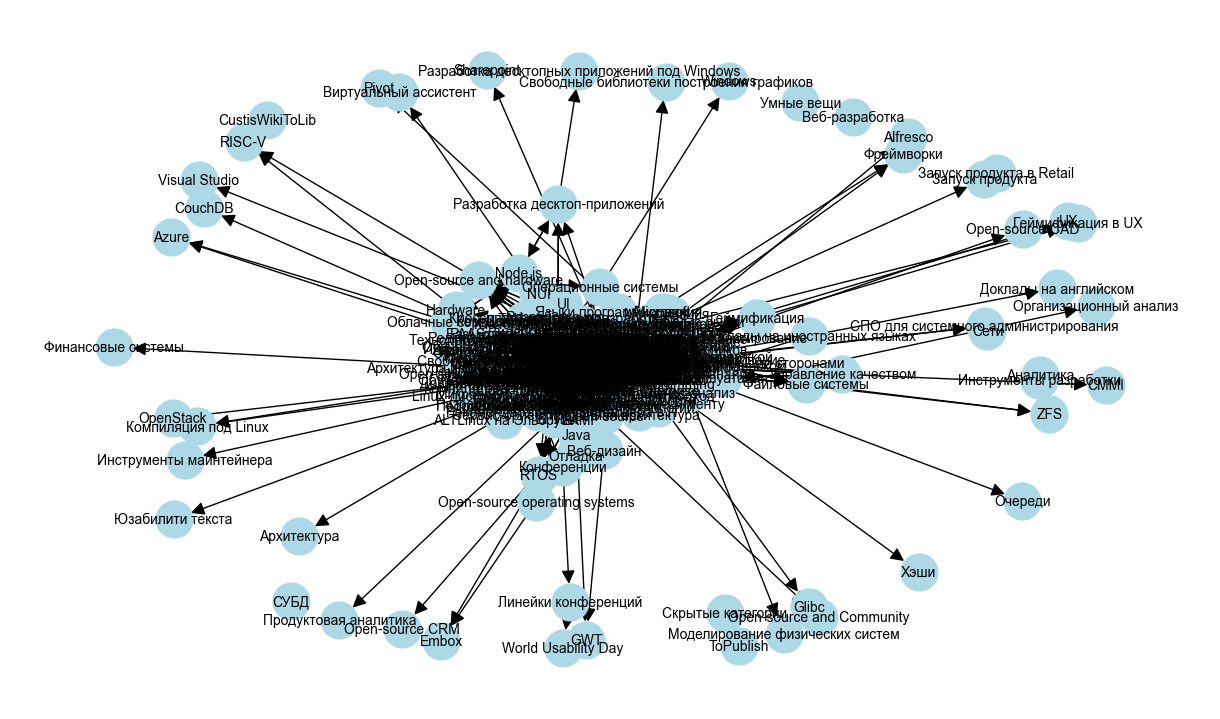

In [24]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, arrowsize=20)
plt.show()

Prepare dataset

In [25]:
X = df["text"].apply(lambda x: " ".join(x))
Y = Y_enc

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(
    lowercase=False, ngram_range=(1, 2), min_df=3, max_features=2000
)
tf_idf_train = vectorizer.fit_transform(X_train_text)
tf_idf_test = vectorizer.transform(X_test_text)

X_train = torch.tensor(tf_idf_train.toarray(), dtype=torch.float32)
X_test = torch.tensor(tf_idf_test.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Build a model

In [26]:
class LabelEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, label_embeddings):
        super(LabelEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, embedding_dim)
        
        self.register_buffer('label_embeddings', torch.tensor(label_embeddings, dtype=torch.float32))
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Compute similarity with label embeddings
        logits = torch.matmul(x, self.label_embeddings.t())  # Shape: (batch_size, num_labels)
        return logits

input_dim = X_train.shape[1]
embedding_dim = label_embeddings_final.shape[1]
num_labels = Y_enc.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LabelEmbeddingModel(input_dim, embedding_dim, label_embeddings_final)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())


#### Train a model with full embeddings

In [27]:
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test.to(device))
        outputs_prob = outputs_test
        outputs_pred = (outputs_prob >= 0.15).int().cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        # Convert predictions and ground truth to label lists
        y_pred_labels = mlb.inverse_transform(outputs_pred)
        y_true_labels = mlb.inverse_transform(y_test_np)

        # Compute IoU metrics for each sample
        iou_scores_v1 = [
            iou_metric(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]
        iou_scores_v2 = [
            iou_metric_v2(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]

        # Calculate average IoU scores
        avg_iou_v1 = np.mean(iou_scores_v1)
        avg_iou_v2 = np.mean(iou_scores_v2)

    if epoch % 10 == 0 or epoch + 1 == num_epochs:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.3f}, Avg IoU_v1: {avg_iou_v1:.3f}, Avg IoU_v2: {avg_iou_v2:.3f}"
        )

Epoch [1/500], Loss: 0.081, Avg IoU_v1: 0.421, Avg IoU_v2: 0.000
Epoch [11/500], Loss: 0.014, Avg IoU_v1: 0.437, Avg IoU_v2: 0.064
Epoch [21/500], Loss: 0.005, Avg IoU_v1: 0.435, Avg IoU_v2: 0.125
Epoch [31/500], Loss: 0.002, Avg IoU_v1: 0.430, Avg IoU_v2: 0.131
Epoch [41/500], Loss: 0.001, Avg IoU_v1: 0.421, Avg IoU_v2: 0.137
Epoch [51/500], Loss: 0.000, Avg IoU_v1: 0.421, Avg IoU_v2: 0.137
Epoch [61/500], Loss: 0.000, Avg IoU_v1: 0.414, Avg IoU_v2: 0.144
Epoch [71/500], Loss: 0.000, Avg IoU_v1: 0.410, Avg IoU_v2: 0.146
Epoch [81/500], Loss: 0.001, Avg IoU_v1: 0.412, Avg IoU_v2: 0.162
Epoch [91/500], Loss: 0.000, Avg IoU_v1: 0.408, Avg IoU_v2: 0.145
Epoch [101/500], Loss: 0.000, Avg IoU_v1: 0.413, Avg IoU_v2: 0.149
Epoch [111/500], Loss: 0.000, Avg IoU_v1: 0.407, Avg IoU_v2: 0.148
Epoch [121/500], Loss: 0.000, Avg IoU_v1: 0.423, Avg IoU_v2: 0.150
Epoch [131/500], Loss: 0.000, Avg IoU_v1: 0.415, Avg IoU_v2: 0.153
Epoch [141/500], Loss: 0.000, Avg IoU_v1: 0.416, Avg IoU_v2: 0.150
Epoch 

#### Train a model with graph embeddings

In [28]:
model = LabelEmbeddingModel(input_dim, node2vec.dimensions, label_embeddings_final[:, 768:])
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test.to(device))
        outputs_prob = outputs_test
        outputs_pred = (outputs_prob >= 0.15).int().cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        # Convert predictions and ground truth to label lists
        y_pred_labels = mlb.inverse_transform(outputs_pred)
        y_true_labels = mlb.inverse_transform(y_test_np)

        # Compute IoU metrics for each sample
        iou_scores_v1 = [
            iou_metric(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]
        iou_scores_v2 = [
            iou_metric_v2(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]

        # Calculate average IoU scores
        avg_iou_v1 = np.mean(iou_scores_v1)
        avg_iou_v2 = np.mean(iou_scores_v2)

    if epoch % 10 == 0 or epoch + 1 == num_epochs:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.3f}, Avg IoU_v1: {avg_iou_v1:.3f}, Avg IoU_v2: {avg_iou_v2:.3f}"
        )

Epoch [1/500], Loss: 0.202, Avg IoU_v1: 0.421, Avg IoU_v2: 0.000
Epoch [11/500], Loss: 0.028, Avg IoU_v1: 0.421, Avg IoU_v2: 0.000
Epoch [21/500], Loss: 0.024, Avg IoU_v1: 0.421, Avg IoU_v2: 0.000
Epoch [31/500], Loss: 0.021, Avg IoU_v1: 0.424, Avg IoU_v2: 0.005
Epoch [41/500], Loss: 0.018, Avg IoU_v1: 0.427, Avg IoU_v2: 0.019
Epoch [51/500], Loss: 0.015, Avg IoU_v1: 0.427, Avg IoU_v2: 0.037
Epoch [61/500], Loss: 0.013, Avg IoU_v1: 0.419, Avg IoU_v2: 0.048
Epoch [71/500], Loss: 0.011, Avg IoU_v1: 0.403, Avg IoU_v2: 0.054
Epoch [81/500], Loss: 0.010, Avg IoU_v1: 0.394, Avg IoU_v2: 0.064
Epoch [91/500], Loss: 0.009, Avg IoU_v1: 0.392, Avg IoU_v2: 0.064
Epoch [101/500], Loss: 0.008, Avg IoU_v1: 0.392, Avg IoU_v2: 0.072
Epoch [111/500], Loss: 0.008, Avg IoU_v1: 0.378, Avg IoU_v2: 0.074
Epoch [121/500], Loss: 0.007, Avg IoU_v1: 0.372, Avg IoU_v2: 0.082
Epoch [131/500], Loss: 0.007, Avg IoU_v1: 0.370, Avg IoU_v2: 0.081
Epoch [141/500], Loss: 0.007, Avg IoU_v1: 0.361, Avg IoU_v2: 0.081
Epoch 

#### Train a model with BERT embeddings

In [29]:
model = LabelEmbeddingModel(input_dim, 768, label_embeddings_final[:, :768])
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test.to(device))
        outputs_prob = outputs_test
        outputs_pred = (outputs_prob >= 0.15).int().cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        # Convert predictions and ground truth to label lists
        y_pred_labels = mlb.inverse_transform(outputs_pred)
        y_true_labels = mlb.inverse_transform(y_test_np)

        # Compute IoU metrics for each sample
        iou_scores_v1 = [
            iou_metric(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]
        iou_scores_v2 = [
            iou_metric_v2(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]

        # Calculate average IoU scores
        avg_iou_v1 = np.mean(iou_scores_v1)
        avg_iou_v2 = np.mean(iou_scores_v2)

    if epoch % 10 == 0 or epoch + 1 == num_epochs:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.3f}, Avg IoU_v1: {avg_iou_v1:.3f}, Avg IoU_v2: {avg_iou_v2:.3f}"
        )

Epoch [1/500], Loss: 0.090, Avg IoU_v1: 0.421, Avg IoU_v2: 0.000
Epoch [11/500], Loss: 0.014, Avg IoU_v1: 0.435, Avg IoU_v2: 0.055
Epoch [21/500], Loss: 0.005, Avg IoU_v1: 0.437, Avg IoU_v2: 0.122
Epoch [31/500], Loss: 0.002, Avg IoU_v1: 0.422, Avg IoU_v2: 0.128
Epoch [41/500], Loss: 0.001, Avg IoU_v1: 0.417, Avg IoU_v2: 0.125
Epoch [51/500], Loss: 0.000, Avg IoU_v1: 0.412, Avg IoU_v2: 0.133
Epoch [61/500], Loss: 0.000, Avg IoU_v1: 0.407, Avg IoU_v2: 0.129
Epoch [71/500], Loss: 0.000, Avg IoU_v1: 0.405, Avg IoU_v2: 0.138
Epoch [81/500], Loss: 0.000, Avg IoU_v1: 0.411, Avg IoU_v2: 0.140
Epoch [91/500], Loss: 0.000, Avg IoU_v1: 0.407, Avg IoU_v2: 0.138
Epoch [101/500], Loss: 0.000, Avg IoU_v1: 0.400, Avg IoU_v2: 0.150
Epoch [111/500], Loss: 0.000, Avg IoU_v1: 0.410, Avg IoU_v2: 0.143
Epoch [121/500], Loss: 0.000, Avg IoU_v1: 0.411, Avg IoU_v2: 0.146
Epoch [131/500], Loss: 0.000, Avg IoU_v1: 0.410, Avg IoU_v2: 0.147
Epoch [141/500], Loss: 0.000, Avg IoU_v1: 0.409, Avg IoU_v2: 0.145
Epoch 

### Summary

|               | Model \ Embedding | Tf-idf (2000) | M-BERT (768) |
|---------------|------------------:|---------------|--------------|
| IoU*          |               kNN | 0.3           | 0.262        |
|               |            LogReg | 0.417         | 0.314        |
|               |    CatBoost (GPU) | 0.458         | 0.315        | 
|               |                   |               |              |
| Training time |               kNN | 30 sec        | 30 sec       |
|               |            LogReg | 9.5 min       | 9.5 min      |
|               |    CatBoost (GPU) | 4 min         | 4 min        |


| IoU*              |   MLP |
|-------------------|------:|
| M-BERT            |  0.38 |
| Node2Vec          |  0.18 |
| M-BERT + Node2Vec | 0.383 |

IoU* = IoU without names and 'HasSpeaker' category

1. Tf-Idf эмбеддинги лучше BERT-овых
2. CatBoost лучше kNN и LogReg
3. Node2Vec эмбеддинги категорий сами по себе ужасны, но в комбинации с BERT-овыми дают микро-плюс

Notes: `iou_metric` возвращает ненулевое значение в случае, когда предсказание не содержит тэгов, а таргет содержит.  
Из-за этого значение этой метрики слишком завышено для тех классификаторов, которые не предсказывают тэги.  
Поэтому, в дальнейшем будем использовать метрику `iou_metric_v2`, в которой такие пары "предсказание - таргет" оцениваются нулём.

Далее, мы запустим grid-search на кросс-валидации для CatBoost (GPU). А затем посмотрим на кач-во Label Embedding + MLP при условии дольшего обучения MLP.

## Grid search

### Prepare data

In [23]:
X = df["text"].apply(lambda x: " ".join(x))
Y = Y_enc

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1, 2),
    min_df=3,
    max_features=2000,
    stop_words=["sep"],
)
tf_idf_train = vectorizer.fit_transform(X_train_text).toarray()
tf_idf_test = vectorizer.transform(X_test_text).toarray()

X_train_ten = torch.tensor(tf_idf_train, dtype=torch.float32)
X_test_ten = torch.tensor(tf_idf_test, dtype=torch.float32)
y_train_ten = torch.tensor(y_train, dtype=torch.float32)
y_test_ten = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_ten, y_train_ten)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### CatBoost + Tf-Idf

In [12]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}
CUTOFF = 0.05
kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
iou_scores = []

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    fold_iou_scores = []

    for train_index, test_index in kf.split(tf_idf_train):
        X_train, X_test = tf_idf_train[train_index], tf_idf_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        frequent_categories_ids = np.flatnonzero(y_train_fold.sum(axis=0) >= 2)
        y_train_filt = y_train_fold[:, frequent_categories_ids]

        catboost_model = CatBoostClassifier(
            loss_function='MultiCrossEntropy',
            random_seed=SEED,
            task_type='GPU',
            verbose=False,
            iterations=150,
            **params
        )

        train_pool = Pool(X_train, y_train_filt)
        catboost_model.fit(train_pool)
        
        y_pred_proba = catboost_model.predict_proba(X_test)
        y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
        y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= CUTOFF).astype(int)
        y_pred = mlb.inverse_transform(y_pred_enc)

        fold_iou_score = np.mean([iou_metric_v2(x, y) for x, y in zip(mlb.inverse_transform(y_test_fold), y_pred)])
        fold_iou_scores.append(fold_iou_score)

    avg_iou_score, std_iou_score = np.mean(fold_iou_scores), np.std(fold_iou_scores)
    iou_scores.append((params, avg_iou_score - std_iou_score))
    print(f"Average IoU score for parameters {params}: {avg_iou_score:.4f} ± {std_iou_score:.4f}")

best_params = max(iou_scores, key=lambda x: x[1])
print(f"Best parameters: {best_params[0]} with IoU score: {best_params[1]}")

Testing parameters: {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Average IoU score for parameters {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.01}: 0.0489 ± 0.0004
Testing parameters: {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Average IoU score for parameters {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.03}: 0.1082 ± 0.0016
Testing parameters: {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Average IoU score for parameters {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.1}: 0.1376 ± 0.0041
Testing parameters: {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
Average IoU score for parameters {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.01}: 0.0438 ± 0.0017
Testing parameters: {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Average IoU score for parameters {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.03}: 0.1067 ± 0.0012
Testing parameters: {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Average IoU score for parameters {'dept

Итак, мы нашли оптимальные параметры для градиентного бустинга при размере эмбеддинга 2000:

`{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.1}`

Зафиксируем эти параметры и найдём оптимальный размер эмбеддинга

In [13]:
EMB_SIZES = (1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000)
CUTOFF = 0.05
kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
iou_scores = []
catboost_params = {'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

for emb_size in EMB_SIZES:
    vectorizer = TfidfVectorizer(
        lowercase=False,
        ngram_range=(1, 2),
        min_df=3,
        max_features=emb_size,
        stop_words=["sep"],
    )
    tf_idf_train = vectorizer.fit_transform(X_train_text).toarray()
    tf_idf_test = vectorizer.transform(X_test_text).toarray()
    
    fold_iou_scores = []

    for train_index, test_index in kf.split(tf_idf_train):
        X_train, X_test = tf_idf_train[train_index], tf_idf_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        frequent_categories_ids = np.flatnonzero(y_train_fold.sum(axis=0) >= 2)
        y_train_filt = y_train_fold[:, frequent_categories_ids]

        catboost_model = CatBoostClassifier(
            loss_function='MultiCrossEntropy',
            random_seed=SEED,
            task_type='GPU',
            verbose=False,
            iterations=150,
            **catboost_params
        )

        train_pool = Pool(X_train, y_train_filt)
        catboost_model.fit(train_pool)
        
        y_pred_proba = catboost_model.predict_proba(X_test)
        y_pred_enc = np.zeros((len(test_index), y_train.shape[1]))
        y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= CUTOFF).astype(int)
        y_pred = mlb.inverse_transform(y_pred_enc)

        fold_iou_score = np.mean([iou_metric_v2(x, y) for x, y in zip(mlb.inverse_transform(y_test_fold), y_pred)])
        fold_iou_scores.append(fold_iou_score)

    avg_iou_score, std_iou_score = np.mean(fold_iou_scores), np.std(fold_iou_scores)
    iou_scores.append((emb_size, avg_iou_score - std_iou_score))
    print(f"Average IoU score for EMB_SIZE = {emb_size}: {avg_iou_score:.4f} ± {std_iou_score:.4f}")

best_params = max(iou_scores, key=lambda x: x[1])
print(f"Best parameters: {best_params[0]} with IoU score: {best_params[1]}")

Average IoU score for EMB_SIZE = 1000: 0.1369 ± 0.0092
Average IoU score for EMB_SIZE = 2000: 0.1605 ± 0.0001
Average IoU score for EMB_SIZE = 3000: 0.1689 ± 0.0039
Average IoU score for EMB_SIZE = 4000: 0.1803 ± 0.0009
Average IoU score for EMB_SIZE = 5000: 0.1769 ± 0.0000
Average IoU score for EMB_SIZE = 6000: 0.1677 ± 0.0018
Average IoU score for EMB_SIZE = 7000: 0.1747 ± 0.0007
Average IoU score for EMB_SIZE = 8000: 0.1733 ± 0.0038
Best parameters: 4000 with IoU score: 0.17946568906851823


Вывод: чем больше размер эмбеддинга, тем выше качество модели.

Но возьмём размер эмбеддинга 4000, т.к. при большем размере эмбеддинга качество крайне слабо растёт

### Label Embedding + MLP

Снова подготовка данных

In [25]:
X = df["text"].apply(lambda x: " ".join(x))
Y = Y_enc

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(
    lowercase=False,
    ngram_range=(1, 2),
    min_df=3,
    max_features=2000,
    stop_words=["sep"],
)
tf_idf_train = vectorizer.fit_transform(X_train_text).toarray()
tf_idf_test = vectorizer.transform(X_test_text).toarray()

X_train_ten = torch.tensor(tf_idf_train, dtype=torch.float32)
X_test_ten = torch.tensor(tf_idf_test, dtype=torch.float32)
y_train_ten = torch.tensor(y_train, dtype=torch.float32)
y_test_ten = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_ten, y_train_ten)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Задание модели

In [31]:
class LabelEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, label_embeddings):
        super(LabelEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, embedding_dim)
        
        self.register_buffer('label_embeddings', torch.tensor(label_embeddings, dtype=torch.float32))
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Compute similarity with label embeddings
        logits = torch.matmul(x, self.label_embeddings.t())  # Shape: (batch_size, num_labels)
        return logits

input_dim = X_train_ten.shape[1]
embedding_dim = label_embeddings_final.shape[1]
num_labels = Y_enc.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LabelEmbeddingModel(input_dim, embedding_dim, label_embeddings_final)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


Обучение

In [ ]:
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_ten.to(device))
        outputs_prob = outputs_test
        outputs_pred = (outputs_prob >= CUTOFF).int().cpu().numpy()
        y_test_np = y_test_ten.cpu().numpy()

        # Convert predictions and ground truth to label lists
        y_pred_labels = mlb.inverse_transform(outputs_pred)
        y_true_labels = mlb.inverse_transform(y_test_np)

        # Compute IoU metrics for each sample
        iou_scores = [
            iou_metric_v2(true_labels, pred_labels)
            for true_labels, pred_labels in zip(y_true_labels, y_pred_labels)
        ]

        avg_iou = np.mean(iou_scores)

    if epoch % 100 == 0 or epoch + 1 == num_epochs:
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.3f}"
        )

Epoch [1/10000], Loss: 0.1667, Avg IoU: 0.000
Epoch [101/10000], Loss: 0.0006, Avg IoU: 0.138
Epoch [201/10000], Loss: 0.0001, Avg IoU: 0.148
Epoch [301/10000], Loss: 0.0001, Avg IoU: 0.165
Epoch [401/10000], Loss: 0.0000, Avg IoU: 0.153
Epoch [501/10000], Loss: 0.0000, Avg IoU: 0.152
Epoch [601/10000], Loss: 0.0000, Avg IoU: 0.151
Epoch [701/10000], Loss: 0.0000, Avg IoU: 0.163
Epoch [801/10000], Loss: 0.0000, Avg IoU: 0.156
Epoch [901/10000], Loss: 0.0000, Avg IoU: 0.164
Epoch [1001/10000], Loss: 0.0000, Avg IoU: 0.165
Epoch [1101/10000], Loss: 0.0000, Avg IoU: 0.162
Epoch [1201/10000], Loss: 0.0000, Avg IoU: 0.163
Epoch [1301/10000], Loss: 0.0000, Avg IoU: 0.157
Epoch [1401/10000], Loss: 0.0000, Avg IoU: 0.166
Epoch [1501/10000], Loss: 0.0000, Avg IoU: 0.156
Epoch [1601/10000], Loss: 0.0000, Avg IoU: 0.164
Epoch [1701/10000], Loss: 0.0000, Avg IoU: 0.164
Epoch [1801/10000], Loss: 0.0000, Avg IoU: 0.165
Epoch [1901/10000], Loss: 0.0000, Avg IoU: 0.160
Epoch [2001/10000], Loss: 0.0000

: 

Вывод: многослойный перцептрон показыавет низкое качество в сравнении с градиентным бустингом

### Итого

1. Дольшее обучение MLP не привело к росту качества
2. CatBoost + Tf-Idf после подбора гиперпараметров показал самое высокое качество на кросс-валидации -- 0.468 IoU

Обучим данную модель на всей обучающей выборке и посмотрим на качество в тесте

In [10]:
X = df["text"].apply(lambda x: " ".join(x))
Y = Y_enc

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

final_params = {
    'catboost': {'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.1},
    'tf-idf': {'max_features': 4000, 'ngram_range': (1, 2), 'min_df': 3},
}

vectorizer = TfidfVectorizer(
    lowercase=False,
    stop_words=["sep"],
    **final_params['tf-idf']
)
tf_idf_train = vectorizer.fit_transform(X_train_text).toarray()
tf_idf_test = vectorizer.transform(X_test_text).toarray()

CUTOFF = 0.05

frequent_categories_ids = np.flatnonzero(y_train.sum(axis=0) >= 2)
y_train_filt = y_train[:, frequent_categories_ids]

catboost_model = CatBoostClassifier(
    loss_function='MultiCrossEntropy',
    random_seed=SEED,
    task_type='CPU',
    verbose=False,
    iterations=150,
    **final_params['catboost']
)

train_pool = Pool(tf_idf_train, y_train_filt)
catboost_model.fit(train_pool)

y_pred_proba = catboost_model.predict_proba(tf_idf_test)
y_pred_enc = np.zeros((len(tf_idf_test), y_train.shape[1]))
y_pred_enc[:, frequent_categories_ids] = (y_pred_proba >= CUTOFF).astype(int)
y_pred = mlb.inverse_transform(y_pred_enc)

test_iou_score = np.mean([iou_metric_v2(x, y) for x, y in zip(mlb.inverse_transform(y_test), y_pred)])
print('Test IoU score:', round(test_iou_score, 3))

Test IoU score: 0.226


Смотрим на предсказания

*Замечание*: и в train, и в test удалены имена и категория `HasSpeaker`. Но их нетрудно навесить поверх текущих предсказаний.

In [11]:
for i, (x, y) in enumerate(zip(mlb.inverse_transform(y_test), y_pred)): 
    print('Prediction:', y)
    print('True Labels:', x)
    print('='*80)
    
    if i >= 30:
        break

Prediction: ('Internet of Thing', 'Кроссплатформенная разработка', 'Мобильная разработка')
True Labels: ('Kotlin', 'Мобильная разработка')
Prediction: ('Java',)
True Labels: ('Kotlin',)
Prediction: ('Talks in English', 'Юзабилити')
True Labels: ('Talks in English',)
Prediction: ('IT-образование', 'Open-source', 'Open-source projects', 'Образование', 'Онлайн-обучение', 'Пиктомир', 'СПО в образовании')
True Labels: ('Open-source', 'Образование')
Prediction: ('Open-source projects', 'Strace')
True Labels: ('Strace',)
Prediction: ('Agile', 'Управление продуктами')
True Labels: ('Управление продуктами',)
Prediction: ()
True Labels: ('WebRTC',)
Prediction: ('Kanban', 'Talks in English')
True Labels: ('Kanban',)
Prediction: ()
True Labels: ('Business rules engine', 'Бизнес-анализ')
Prediction: ('Open-source', 'Open-source projects', 'Образование', 'СПО в образовании')
True Labels: ('Open-source', 'Образование')
Prediction: ('Linux', 'Linux-дистрибутивы для Enterprise', 'Open-source projects',

In [ ]:
with open('models/catboost_with_tf_idf_v1.pkl', 'wb') as fd:
    pickle.dump(catboost_model, fd)

## Дополнения